**LLM Workshop 2024 by Sebastian Raschka**

This code is based on *Build a Large Language Model (From Scratch)*, [https://github.com/rasbt/LLMs-from-scratch](https://github.com/rasbt/LLMs-from-scratch)

In [ ]:
# Requirements from: https://github.com/rasbt/LLM-workshop-2024/blob/main/requirements.txt
requirements = """
# torch >= 2.0.1
tiktoken >= 0.5.1
# matplotlib >= 3.7.1
# numpy >= 1.24.3
# tensorflow >= 2.15.0
# tqdm >= 4.66.1
# numpy >= 1.25, < 2.0
# pandas >= 2.2.1
# psutil >= 5.9.5
# litgpt[all] >= 0.4.1
"""

with open("requirements.txt", mode="wt") as f:
    f.write(requirements)

%pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.0 MB/s eta 0:00:00


In [ ]:
# Check if a package is installed in the current environment
import importlib
importlib.util.find_spec("tiktoken")

ModuleSpec(name='tiktoken', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f431dba5c30>, origin='/usr/local/lib/python3.10/dist-packages/tiktoken/__init__.py', submodule_search_locations=['/usr/local/lib/python3.10/dist-packages/tiktoken'])

In [ ]:
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.3.0+cu121
tiktoken version: 0.7.0


Add supplementary Python module from Sebastian Raschka's training material

In [ ]:
import requests
session = requests.Session()
with open("supplementary.py", "wt", encoding="utf-8") as f:
    response = session.get("https://raw.githubusercontent.com/rasbt/LLM-workshop-2024/main/04_pretraining/supplementary.py")
    f.write(response.text)

Add text dataset from Sebastian Raschka's training material

In [ ]:
session = requests.Session()
with open("the-verdict.txt", "wt", encoding="utf-8") as f:
    response = session.get("https://raw.githubusercontent.com/rasbt/LLM-workshop-2024/main/04_pretraining/the-verdict.txt")
    f.write(response.text)

Add my own text dataset: Jane Austen's books, from Project Gutenberg

In [ ]:
import re  # regular expressions, for extracting text from books
import requests  # for accessing books from URLs
from pathlib import Path  # for creating a directory to store books

book_names = [
    'Pride and Prejudice',
    'Emma',
    'Sense and Sensibility',
    'Persuasion',
    'Northanger Abbey',
    'Mansfield Park',
    'Lady Susan'
]

book_urls = [
    'https://www.gutenberg.org/files/1342/1342-0.txt',
    'https://www.gutenberg.org/cache/epub/158/pg158.txt',
    'https://www.gutenberg.org/files/161/161-0.txt',
    'https://www.gutenberg.org/cache/epub/105/pg105.txt',
    'https://www.gutenberg.org/files/121/121-0.txt',
    'https://www.gutenberg.org/files/141/141-0.txt',
    'https://www.gutenberg.org/cache/epub/946/pg946.txt'
]

# Create a folder to save the books in
book_directory = Path('./books/')
if not book_directory.exists():
    book_directory.mkdir()

jane_austen_full_text = ''

session = requests.Session()

# Save books to a folder so they can be accessed later if needed
# Also save the entire text in the jane_austen_full_text variable
for num, url in enumerate(book_urls):
    response = session.get(url)
    # Ensure the response text is properly formatted as utf-8
    # See: https://stackoverflow.com/a/44203507/17005348
    response.encoding = 'UTF-8'
    book_text = response.text
    book_title = book_names[num].replace(' ', '_')
    with open(f'./books/{book_title}.txt', mode='w+', encoding='utf-8') as book_file:
        book_file.write(book_text)

    # Save the text to the jane_austen_full_text variable,
    # removing the intro and end parts from Project Gutenberg
    # which have this form: *** BEGIN BOOK *** or *** END OF BOOK ***
    jane_austen_full_text += re.split(r'[*]{3}.*?[*]{3}', string=book_text)[1]

with open(f'./books/jane_austen.txt', mode='w+', encoding='utf-8') as book_file:
    book_file.write(jane_austen_full_text)

print(f'Total number of characters: {len(jane_austen_full_text):,d}')

Total number of characters: 4,268,240


# 4) Pretraining LLMs

In [ ]:
from importlib.metadata import version

pkgs = [
    "matplotlib",
    "numpy",
    "tiktoken",
    "torch",
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.7.1
numpy version: 1.25.2
tiktoken version: 0.7.0
torch version: 2.3.0+cu121


- In this notebook, we implement the training loop and code for basic model evaluation to pretrain an LLM

<img src="https://github.com/rasbt/LLM-workshop-2024/blob/main/04_pretraining/figures/01.png?raw=1" width=1000px>

<br>
<br>
<br>
<br>



# 4.1 Using GPT to generate text

In [ ]:
import gc

import torch

# First, delete all references to the model, the optimizer, and the loss
# See: https://discuss.pytorch.org/t/free-all-gpu-memory-used-in-between-runs/168202/3
# and https://saturncloud.io/blog/how-to-clear-gpu-memory-after-pytorch-model-training-without-restarting-kernel/
# del model
# del optimizer
# del train_loss
# del val_loss

# Then, run Python's garbage collection
gc.collect()

# Finally, clear the cache with Pytorch
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Tue Jul  9 20:33:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              34W /  70W |   1455MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

- We initialize a GPT model using the code from the previous notebook

In [ ]:
import torch
from supplementary import GPTModel


GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()  # Disable dropout during inference

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

- We use dropout of 0.1 above, but it's relatively common to train LLMs without dropout nowadays
- Modern LLMs also don't use bias vectors in the `nn.Linear` layers for the query, key, and value matrices (unlike earlier GPT models), which is achieved by setting `"qkv_bias": False`
- We reduce the context length (`context_length`) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens

- Next, we use the `generate_text_simple` function from the previous chapter to generate text
- In addition, we define two convenience functions, `text_to_token_ids` and `token_ids_to_text`, for converting between token and text representations that we use throughout this chapter

<img src="https://github.com/rasbt/LLM-workshop-2024/blob/main/04_pretraining/figures/02.png?raw=1" width=1200px>

In [ ]:
import tiktoken
from supplementary import generate_text_simple


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [ ]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- As we can see above, the model does not produce good text because it has not been trained yet
- How do we measure or capture what "good text" is, in a numeric form, to track it during training?
- The next subsection introduces metrics to calculate a loss metric for the generated outputs that we can use to measure the training progress
- The next chapters on finetuning LLMs will also introduce additional ways to measure model quality

---

# 4.2 Preparing the dataset loaders

- We use a relatively small dataset for training the LLM (in fact, only one short story)
  - The training finishes relatively fast (minutes instead of weeks), which is good for educational purposes
- For example, Llama 2 7B required 184,320 GPU hours on A100 GPUs to be trained on 2 trillion tokens

- Below, we use the same dataset we used in the data preparation notebook earlier

In [ ]:
with open("the-verdict.txt", "r", encoding="utf-8") as file:
    text_data = file.read()

Use my own text dataset

In [ ]:
with open(f'./books/jane_austen.txt', mode='rt', encoding='utf-8') as f:
    text_data = f.read()

- A quick check that the text loaded ok by printing the first and last 100 words

In [ ]:
# First 100 characters
print(text_data[:99])

In [ ]:
# Last 100 characters
print(text_data[-99:])

In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print(f"Characters: {total_characters:,d}")
print(f"Tokens: {total_tokens:,d}")

Characters: 4,189,924
Tokens: 1,076,748


- With 5,145 tokens, the text is very short for training an LLM, but again, it's for educational purposes (we will also load pretrained weights later)

- Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training
- For visualization purposes, the figure below assumes a `max_length=6`, but for the training loader, we set the `max_length` equal to the context length that the LLM supports
- The figure below only shows the input tokens for simplicity
    - Since we train the LLM to predict the next word in the text, the targets look the same as these inputs, except that the targets are shifted by one position

<img src="https://github.com/rasbt/LLM-workshop-2024/blob/main/04_pretraining/figures/03.png?raw=1" width=1500px>

In [ ]:
from supplementary import create_dataloader_v1


# Train/validation ratio
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=16,  # 16 is the largest I can do on a 15GB T4 GPU on Colab. Training uses 14.1GB of memory.
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=16,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

- We use a relatively small batch size to reduce the computational resource demand, and because the dataset is very small to begin with
- Llama 2 7B was trained with a batch size of 1024, for example

- An optional check that the data was loaded correctly:

In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 256]) torch.Size([16, 256])
torch.Size([16, 25

- Another optional check that the token sizes are in the expected ballpark:

In [ ]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print(f"Training tokens: {train_tokens:,d}")
print(f"Validation tokens: {val_tokens:,d}")
print(f"All tokens: {train_tokens + val_tokens:,d}")

Training tokens: 1,024,000
Validation tokens: 51,712
All tokens: 1,075,712


- Next, let's calculate the initial loss before we start training

- If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code
- Via the `device` setting, we ensure that the data is loaded onto the same device as the LLM model

In [ ]:
from supplementary import calc_loss_loader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # no assignment (model = model.to(device)) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.97886494064331
Validation loss: 10.985034502469576


<br>
<br>
<br>
<br>



# 4.2 Training an LLM

- In this section, we finally implement the code for training the LLM

<img src="https://github.com/rasbt/LLM-workshop-2024/blob/main/04_pretraining/figures/04.png?raw=1" width=700px>

In [ ]:
from supplementary import (
    calc_loss_batch,
    evaluate_model,
    generate_and_print_sample
)


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

- Now, let's train the LLM using the training function defined above:

In [87]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="I like to look for rainbows", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.571, Val loss 9.652
Ep 1 (Step 000005): Train loss 7.839, Val loss 7.905
Ep 1 (Step 000010): Train loss 6.748, Val loss 6.875
Ep 1 (Step 000015): Train loss 6.324, Val loss 6.575
Ep 1 (Step 000020): Train loss 6.248, Val loss 6.484
Ep 1 (Step 000025): Train loss 6.233, Val loss 6.347
Ep 1 (Step 000030): Train loss 5.929, Val loss 6.260
Ep 1 (Step 000035): Train loss 5.931, Val loss 6.157
Ep 1 (Step 000040): Train loss 5.770, Val loss 6.052
Ep 1 (Step 000045): Train loss 5.697, Val loss 5.965
Ep 1 (Step 000050): Train loss 5.640, Val loss 5.883
Ep 1 (Step 000055): Train loss 5.614, Val loss 5.834
Ep 1 (Step 000060): Train loss 5.527, Val loss 5.785
Ep 1 (Step 000065): Train loss 5.461, Val loss 5.736
Ep 1 (Step 000070): Train loss 5.496, Val loss 5.687
Ep 1 (Step 000075): Train loss 5.341, Val loss 5.648
Ep 1 (Step 000080): Train loss 5.370, Val loss 5.618
Ep 1 (Step 000085): Train loss 5.425, Val loss 5.573
Ep 1 (Step 000090): Train loss 5.379, Val loss

In [88]:
torch.save(model.state_dict(), "model.pth")

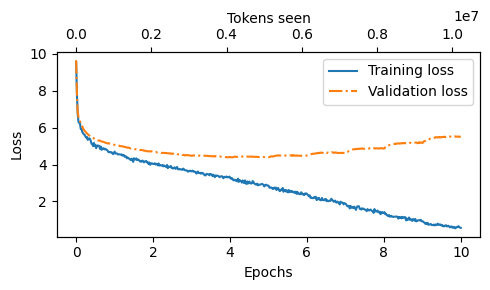

In [89]:
from supplementary import plot_losses


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- Looking at the results above, we can see that the model starts out generating incomprehensible strings of words, whereas towards the end, it's able to produce grammatically more or less correct sentences
- However, based on the training and validation set losses, we can see that the model starts overfitting
- If we were to check a few passages it writes towards the end, we would find that they are contained in the training set verbatim -- it simply memorizes the training data

- There are decoding strategies (not covered in this workshop) that can mitigate this memorization by a certain degree
- Also note that the overfitting here occurs because we have a very, very small training set, and we iterate over it so many times
  - The LLM training here primarily serves educational purposes; we mainly want to see that the model can learn to produce coherent text
  - Instead of spending weeks or months on training this model on vast amounts of expensive hardware, we load pretrained weights later

---

# Exercise 1: Generate text from the pretrained LLM

- Use the model to generate new text (HINT: scroll up to see how we generated text before)

In [99]:
start_context = "It is a truth, universally acknowledged"
tokenizer = tiktoken.get_encoding("gpt2")

model.eval()
token_ids = generate_text_simple(
    model=model.to("cpu"),
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=20,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer), sep="")

Output text:
It is a truth, universally acknowledged.”

“That’s true.”

“That


---

# Exercise 2: Load the pretrained model in a new session

- Open a new Python session or Jupyter notebook and load the model there

In [ ]:
# See: https://pytorch.org/tutorials/beginner/saving_loading_models.html
# and: https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

import torch
from supplementary import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # place the model on the applicable device
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"), map_location=device)
model.eval()  # Disable dropout during inference

---

# Solution to Exercise 1

In [ ]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

In [ ]:
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

---

# Solution to Exercise 2

In [ ]:
import torch

# Imports from a local file
from supplementary import GPTModel


model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval();